In [1]:
# model
import xgboost as xgb

# sampler
from imblearn.under_sampling import RandomUnderSampler

# custom modules
from utils import set_seed, get_clf_eval, make_submission, record_experimental_results
import preprocessing as pp

### Global Setting

In [2]:
hparams = {
    'seed': 33
}

In [3]:
set_seed(hparams['seed'])

### 실험 01: `XGBClassifier()`

In [201]:
# xgb global configuration
xgb.config_context(**{'verbosity': 2})

In [202]:
# xgb general parameters
general_hparams = {
    'booster': 'gbtree', # which booster to use. Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.
    'device': 'cuda', # Device for XGBoost to run.
    'verbositiy': 2, # Verbosity of printing messages.
    'validate_parameters': False, # When set to True, XGBoost will perform validation of input parameters to check whether a parameter is used or not.
    # 'nthread': ??? # Number of parallel threads used to run XGBoost.
    'disable_default_eval_metric': False, # Flag to disable default metric.
}

In [203]:
# tree hyperparameters
treeBooster_hparams = {
    'eta': 0.3, # Step size shrinkage used in update to prevents overfitting. (=learning rate)
    'gamma': 0, # Minimum loss reduction required to make a further partition on a leaf node of the tree. (=min_split_loss)
    'max_depth': 6, # Maximum depth of a tree.
    'min_child_weight': 1, # Minimum sum of instance weight (hessian) needed in a child. (=min_pruning_val)
    'max_delta_step': 0, # Maximum delta step we allow each leaf output to be. (???)
    'subsample': 1, # Subsample ratio of the training instances
    'sampling_method': 'uniform', # The method to use to sample the training instances.
    'colsample_bytree': 1, # the subsample ratio of columns when constructing each tree. (=min_features)
    'colsample_bylevel': 1, # the subsample ratio of columns for each level.
    'colsample_bynode': 1, #  the subsample ratio of columns for each node (split).
    'lambda': 1, # L2 regularization term on weights.
    'alpha': 0, # L1 regularization term on weights.
    'tree_method': 'auto', # The tree construction algorithm used in XGBoost.
    'scale_pos_weight': 1, # Control the balance of positive and negative weights, useful for unbalanced classes.
    # 'updater': ??, # A comma separated string defining the sequence of tree updaters to run, providing a modular way to construct and to modify the trees.
    # 'refresh_leaf': 1, # This is a parameter of the refresh updater.
    'process_type': 'default', # A type of boosting process to run. (=warmup)
    'grow_policy': 'depthwise', # Controls a way new nodes are added to the tree.
    'max_leaves': 0, # Maximum number of nodes to be added.
    'max_bin': 256, # Only used if tree_method is set to hist or approx. (Maximum number of discrete bins to bucket continuous features.)
    'num_parellel_tree': 1, # Number of parallel trees constructed during each iteration. (This option is used to support boosted random forest.)
    # 'monotone_constraints': ??,
    # 'interaction_constraints': ??,
    'multi_strategy': 'one_output_per_tree', # The strategy used for training multi-target models, including multi-target regression and multi-class classification.
    'max_cached_hist_node': 65536, # Maximum number of cached nodes for CPU histogram.
}

In [204]:
# task hyperparameters
task_hparams = {
    'objective': 'binary:logistic', # Specify the learning task and the corresponding learning objective.
    # 'base_score': , # The initial prediction score of all instances, global bias
    # 'eval_metric': # Evaluation metrics for validation data, a default metric will be assigned according to objective
    'seed': hparams['seed'], # Random number seed.
    'seed_per_iteration': False, # Seed PRNG determnisticly via iterator number.
}

In [268]:
tr_data, tt_data = pp.load_data()
tr_data.drop_duplicates()

59299

In [205]:
# data load & label encoding
tr_data, tt_data = pp.load_data()
x_tr, x_tt = pp.label_encoding(tr_data, tt_data)
x_tr, y_tr, x_val, y_val = pp.split_train_and_validation(x_tr, val_size=0.1, seed=hparams['seed'])

In [206]:
rus = RandomUnderSampler(random_state=hparams['seed'])
x_val, y_val = rus.fit_resample(x_val, y_val)
len(x_val), len(y_val)

(898, 898)

In [207]:
# # data load & label encoding
# tr_data, tt_data = pp.load_data()
# x_tr, x_tt = pp.label_encoding(tr_data, tt_data)

# # 서로 다른 seed를 이용하여 undersampling 수행
# rus = RandomUnderSampler(random_state=hparams['seed'])
# x_tr_res, y_tr_res = rus.fit_resample(x_tr.drop(['is_converted'], axis=1), x_tr['is_converted'])

# # train / validation split
# x_tr_res['is_converted'] = y_tr_res # concat
# x_tr, y_tr, x_val, y_val = pp.split_train_and_validation(x_tr_res, seed=hparams['seed'])

In [256]:
treeBooster_hparams_ablation = treeBooster_hparams.copy()

treeBooster_hparams_ablation['scale_pos_weight'] = len(tr_data[tr_data['is_converted'] == False]) / len(tr_data[tr_data['is_converted'] == True])
treeBooster_hparams_ablation['max_depth'] = None
treeBooster_hparams_ablation['lambda'] = 10
treeBooster_hparams_ablation['eta'] = 0.05

In [257]:
xgbc = xgb.XGBClassifier(**general_hparams, **treeBooster_hparams_ablation, **task_hparams)

In [258]:
xgbc.fit(x_tr.fillna(0), y_tr)

c:\Users\qkrtn\miniconda3\envs\lgaimers\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_parellel_tree", "verbositiy" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device='cuda', disable_default_eval_metric=False,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, feature_types=None, gamma=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=10, learning_rate=None,
              max_bin=256, max_cached_hist_node=65536, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=None,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints=None, ...)

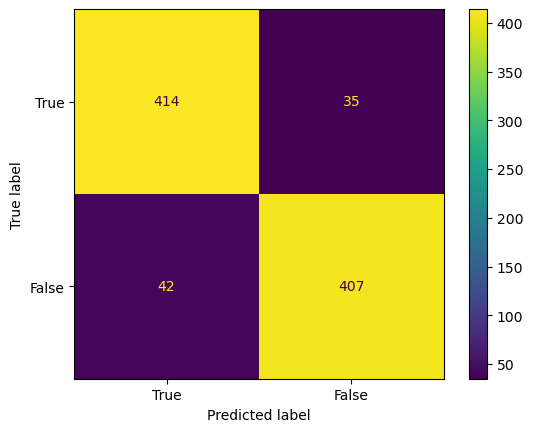


정확도: 0.9143
정밀도: 0.9079
재현율: 0.9220
F1: 0.9149


In [259]:
# check validation score
y_val_pred = xgbc.predict(x_val.fillna(0))
get_clf_eval(y_val, y_val_pred)

In [260]:
# test
# x_tt = x_tt.drop(['is_converted', 'id'], axis=1)

In [261]:
y_test_pred = xgbc.predict(x_tt.fillna(0))
sum(y_test_pred)

1831

In [262]:
model_name = 'baseline_xgb_decEta'

In [263]:
make_submission(dir_name='06_xgboost',
                y_pred=y_test_pred,
                model_name=model_name)

**Record**

In [264]:
record_experimental_results(model_name=model_name,
                            test_f1_score='0.6844741235392321',
                            description='xgboost baseline에서 eta를 0.05로 줄임')